## MSA on PyTorch Network trained on MNIST 

This is an example of how we can perform **"Multiperturbation Shapley value Analysis"** on a PyTorch neural network. We train a three layer [input, hidden, output] network with 32 neurons in the hidden layer. We use MSA to analyse the contribution of each neuron in the hidden layer in accurately predicting the classes. 

In [14]:
import sys
sys.path.append('/home/hiwi/Desktop/msa')

# Imports
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# ---------
from msapy import msa, utils as ut, plottings as pl
# ---------
from functools import partial
from typing import Union, Optional, List

CM = 1 / 2.54
SEED = 42
RNG = np.random.default_rng(SEED)
FIGPATH = "figures/mnist/"

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T

from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets

In [16]:
# Device configuration
device = torch.device('cpu')
device

device(type='cpu')

### Loading Data

In [17]:
mnist_transforms = T.Lambda(lambda x: torch.flatten(x, 1)/255)

train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = mnist_transforms, 
    download = True,            
)

test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = mnist_transforms
)

train_data = TensorDataset(mnist_transforms(train_data.data.to(device)), train_data.targets.to(device))
test_data = TensorDataset(mnist_transforms(test_data.data.to(device)), test_data.targets.to(device))

In [18]:
trainloader = DataLoader(train_data, 
                        batch_size=64, 
                        shuffle=True)
    
testloader = DataLoader(test_data, 
                        batch_size=1024)

### Model Definition

In [19]:
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.layer1 = nn.Linear(28*28, 32)
        self.layer2 = nn.Sequential(nn.LeakyReLU(),
                                    nn.Linear(32, 10))

    def forward(self, x: torch.Tensor, lesion_idx: Optional[Union[int, List[int]]] = None) -> torch.Tensor:
        """forward function to calculate the scores for each class

        Args:
            x (torch.Tensor): data of shape [batch_size, 28*28]
            lesion_idx (Optional[Union[int,List[int]]], optional): the neuron that we want to lesion in the hidden layer1. Defaults to None i.e. no lesioning performed.

        Returns:
            torch.Tensor: scores for each class
        """
        out = self.layer1(x)

        if lesion_idx:
            out[:, lesion_idx] = 0  # set the value to 0 for the lesioned neuron

        return self.layer2(out)


model = MNISTNet().to(device)


### Training the Model

In [20]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

In [21]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 400 == 399:    # print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 400:.3f}')
            running_loss = 0.0

print('Finished Training')


[1,   400] loss: 0.376
[1,   800] loss: 0.220
[2,   400] loss: 0.166
[2,   800] loss: 0.173
Finished Training


## MSA

In [22]:
@torch.no_grad()
def test_accuracy(lesion_idx: Optional[Union[int, List[int]]] = None, num_batches: int = -1) -> float:
    """return the accuracy of the model on test dataset

    Args:
        lesion_idx (Optional[Union[int,List[int]]], optional): the neuron that we want to lesion in the hidden layer1. Defaults to None i.e. no lesioning performed.
        num_batches (int, optional): the number of batches we want to test our model. Defaults to -1 i.e. all data

    Returns:
        float: test accuracy
    """
    correct = 0
    total = 0

    for i, data in enumerate(testloader):
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images, lesion_idx)
        # the class with the highest score is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i == (num_batches-1):
            return (correct/total)*100

    return (correct/total)*100


In [23]:
print(f"the accuracy of the model on the first batch without leasoning is: {test_accuracy(num_batches=1)}")

the accuracy of the model on the first batch without leasoning is: 94.7265625


In [24]:
ground_truth_elements = list(range(32)) #Indices for the neurons in the hidden layer
print(f'total number of possible lesions: {2**len(ground_truth_elements)}')

total number of possible lesions: 4294967296


Now we perform the MSA to calculate the contributions for each neuron

#### Note: You might want to change the device to cpu while running MSA if you have to load the data into the GPU at every iteration. This could become a bottleneck. If your data is already on the gpu than it's not a problem

In [25]:
shapley_table, _, _ = msa.interface(
    elements=ground_truth_elements,
    n_permutations=1000, # might want to increase it for better results
    objective_function=partial(test_accuracy, num_batches=1), #only the first batch to save time. But the batch size is 1024 i.e ~100 images per class
    n_parallel_games=-1, #parallelized over all CPU cores
    rng=RNG)

Playing the games:   4%|▍         | 1224/27682 [01:50<39:50, 11.07it/s]

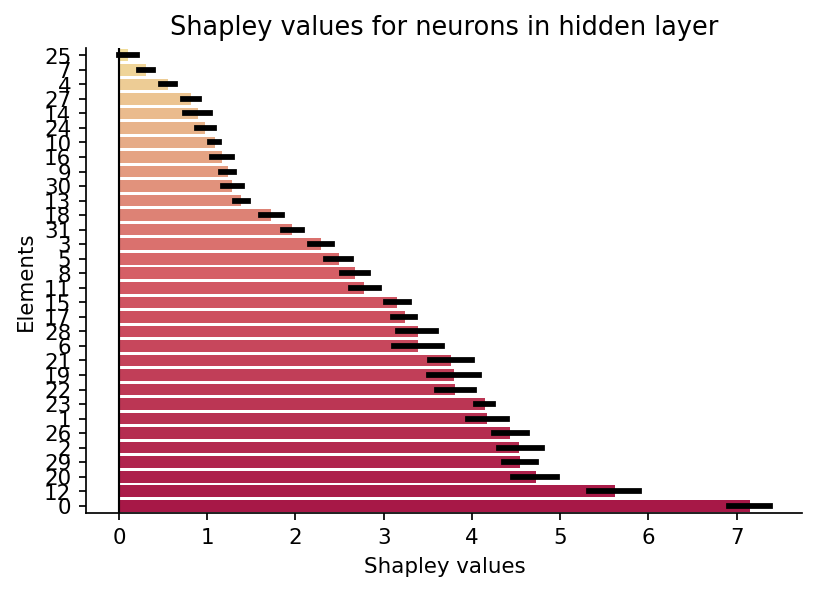

In [ ]:
shapley_table = ut.sorter(shapley_table) # sorting based on the average contribution (Shapley values)

fig,ax = plt.subplots()
colors = pl.color_code(shapley_table=shapley_table)
pl.plot_shapley_ranks(shapley_table=shapley_table,colors=colors,ax=ax)
fig.set_dpi(154)
plt.xlabel('Shapley values')
plt.ylabel('Elements')
plt.title('Shapley values for neurons in hidden layer')
plt.savefig(f"{FIGPATH}Shapley.pdf",dpi=300,bbox_inches='tight')